In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/subband_features/train_set.csv'
val_path = '/content/drive/MyDrive/subband_features/val_set.csv'
test_path = '/content/drive/MyDrive/subband_features/test_set.csv'

Epoch 1/250
110/110 - 45s - 412ms/step - accuracy: 0.5469 - loss: 4.5141 - val_accuracy: 0.5000 - val_loss: 3.2237 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 27s - 245ms/step - accuracy: 0.6894 - loss: 3.3266 - val_accuracy: 0.5000 - val_loss: 2.4334 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 40s - 362ms/step - accuracy: 0.7920 - loss: 2.5028 - val_accuracy: 0.5000 - val_loss: 1.9009 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 24s - 219ms/step - accuracy: 0.8706 - loss: 1.9225 - val_accuracy: 0.5000 - val_loss: 1.5458 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 42s - 379ms/step - accuracy: 0.8943 - loss: 1.5581 - val_accuracy: 0.5027 - val_loss: 1.2855 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 41s - 376ms/step - accuracy: 0.9171 - loss: 1.2990 - val_accuracy: 0.8797 - val_loss: 0.9343 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 41s - 376ms/step - accuracy: 0.9371 - loss: 1.1065 - val_accuracy: 0.7905 - val_loss: 0.8459 - learning_rate: 5.0000e-04

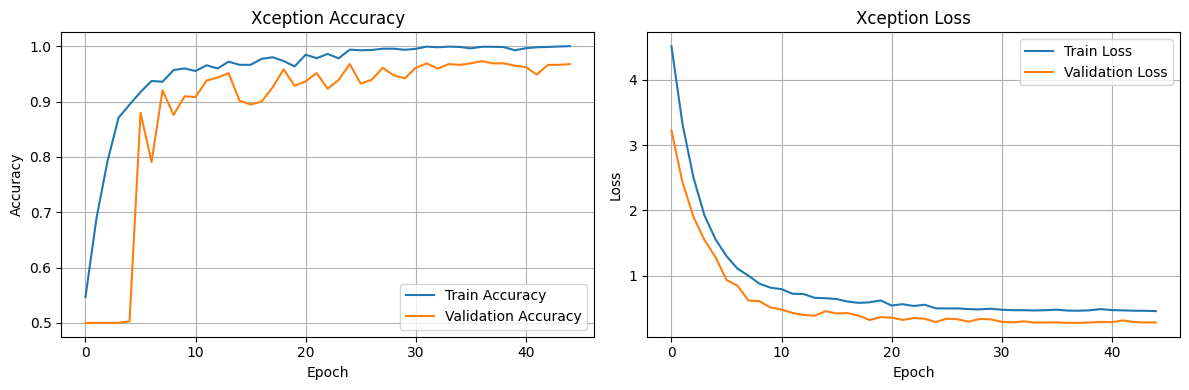

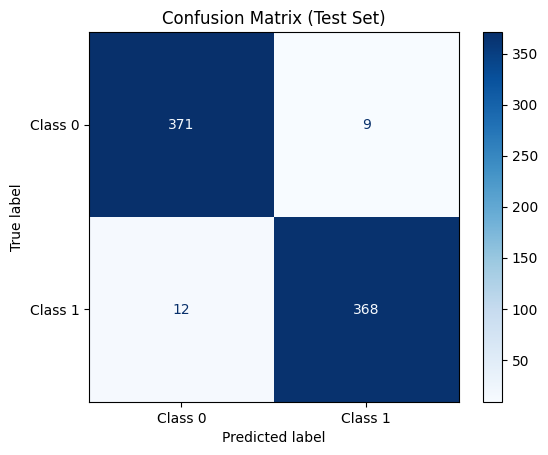

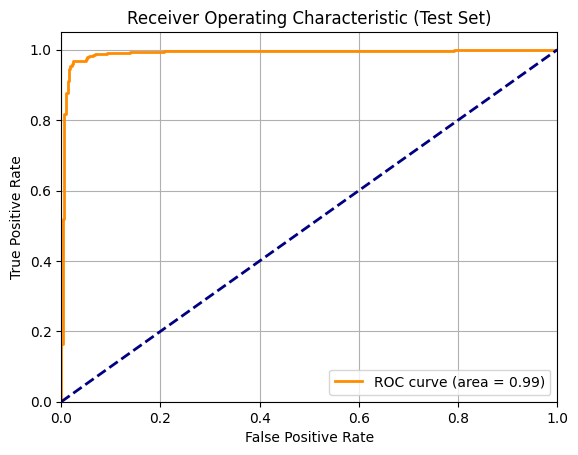

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.01)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 20ms/step - accuracy: 0.9724 - loss: 0.2800
Test Accuracy: 0.9724
Test Loss: 0.2800


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


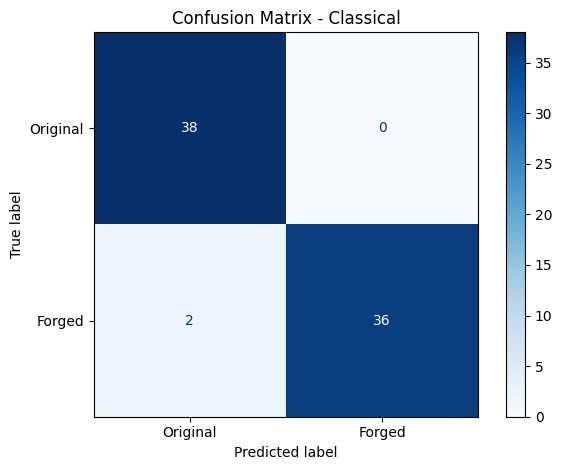

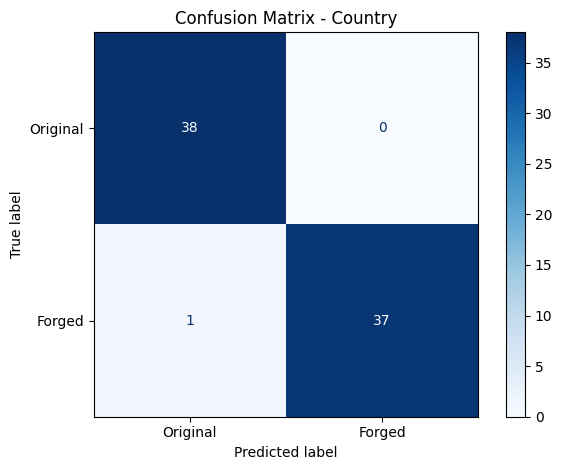

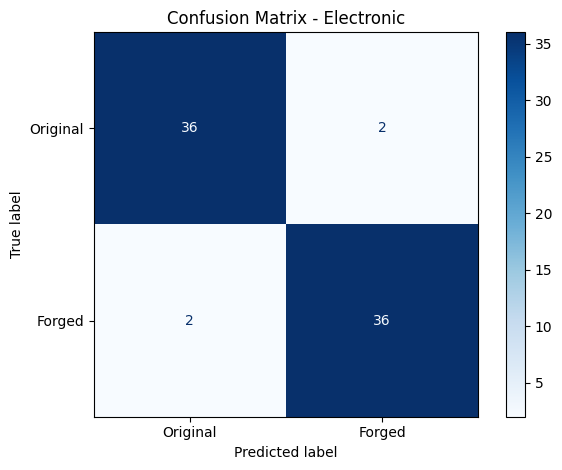

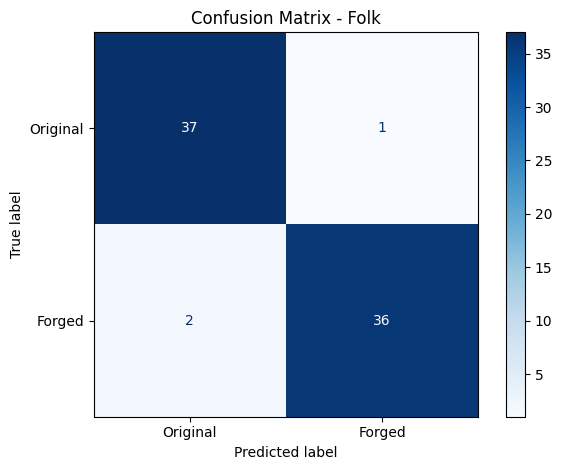

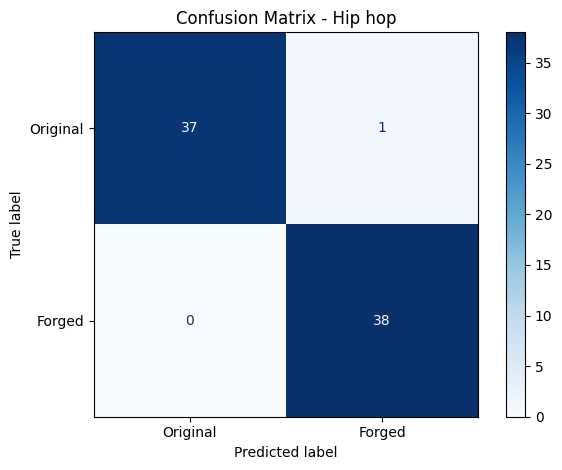

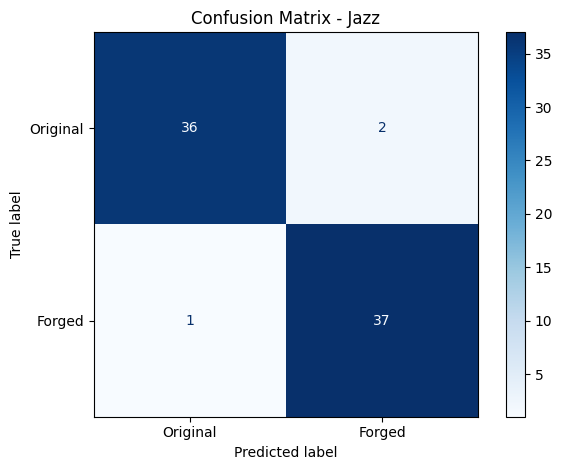

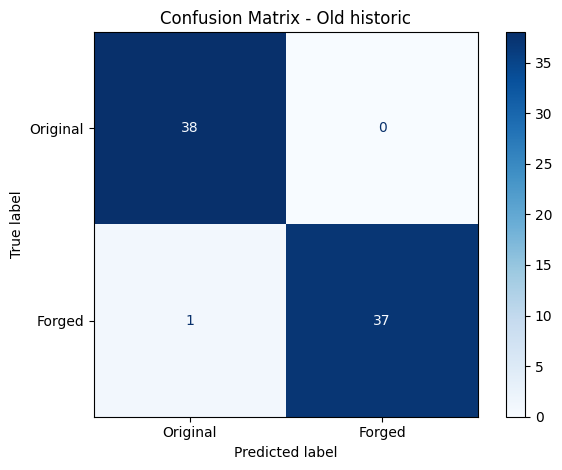

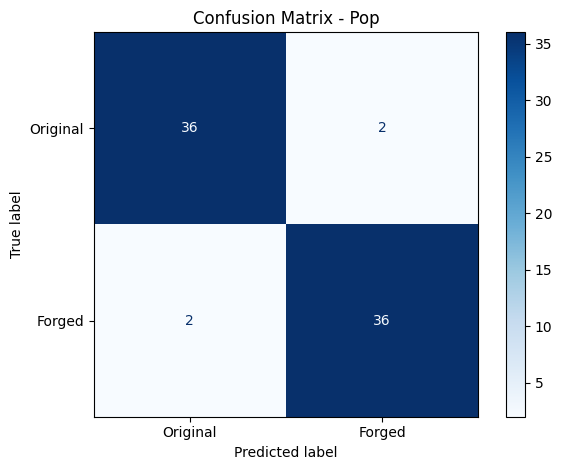

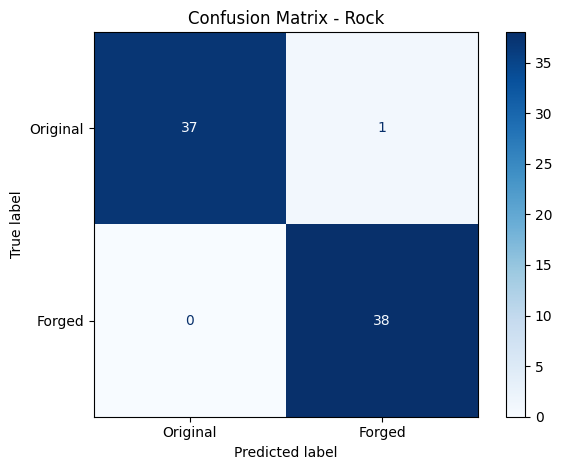

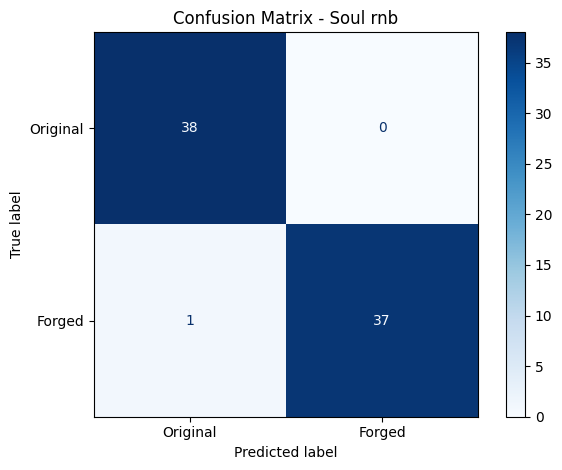

In [ ]:
# Reload test data with genre column
test_data_full = pd.read_csv(test_path)

# Ensure order is preserved after reshaping
X_test_full = test_data_full[feature_columns].values.reshape(-1, len(feature_columns), 1)
y_test_full = test_data_full['class'].values
genres = test_data_full['genre'].values

# Unique genres
unique_genres = sorted(test_data_full['genre'].unique())

# Predict on all test samples
y_pred_all = (model.predict(X_test_full) > 0.5).astype(int).flatten()
y_pred_proba_all = model.predict(X_test_full).flatten()

# Store metrics per genre
genre_metrics = []

for genre in unique_genres:
    # Genre-wise filtering
    genre_indices = np.where(genres == genre)[0]
    y_true = y_test_full[genre_indices]
    y_pred = y_pred_all[genre_indices]
    y_proba = y_pred_proba_all[genre_indices]

    # Compute metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    acc = np.mean(y_true == y_pred)

    # Save metrics
    genre_metrics.append({
        'Genre': genre,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Original', 'Forged'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {genre.capitalize()}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# Convert to DataFrame
genre_metrics_df = pd.DataFrame(genre_metrics)
print("\nGenre-Based Evaluation:")
print(genre_metrics_df.sort_values(by='Genre'))


Genre-Based Evaluation:
          Genre  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0     classical  0.973684   1.000000  0.947368  0.972973  1.000000
1       country  0.986842   1.000000  0.973684  0.986667  0.992382
2    electronic  0.947368   0.947368  0.947368  0.947368  0.987535
3          folk  0.960526   0.972973  0.947368  0.960000  0.970222
4       hip hop  0.986842   0.974359  1.000000  0.987013  1.000000
5          jazz  0.960526   0.948718  0.973684  0.961039  0.960526
6  old historic  0.986842   1.000000  0.973684  0.986667  0.998615
7           pop  0.947368   0.947368  0.947368  0.947368  0.997230
8          rock  0.986842   0.974359  1.000000  0.987013  0.998615
9      soul RnB  0.986842   1.000000  0.973684  0.986667  0.998615
